In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
try:
    import fastbook
    print(f"fastbook version: {fastbook.__version__}")
except ImportError:
    print("fastbook is not installed.")


fastbook version: 0.0.29


In [18]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [14]:
#hide 
!pip install -Uqq fastai

In [23]:

path = untar_data(URLs.MNIST_SAMPLE)

In [21]:
#hide
Path.BASE_PATH = path

In [24]:


path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [25]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [26]:
(path/'valid').ls()

(#2) [Path('valid/7'),Path('valid/3')]

In [55]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
sevens

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

In [42]:
im3 = Image.open(threes[1])
im3

In [43]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [44]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

array and tensor allows us to see an image represented as an array. [4:10,4:10] allow us to see the lets use see rows 4 - 10 and columns 4-10. 2d array, so row is len(array), column is len(array[0])


In [47]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


**The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels. This is much smaller than an image that you would get from a phone camera whihc has millions of pixels**

Numpy array: each number in the array represents the intensity or color value of a pizel in the image. The interpretation of these values depends on the type of image.

Grayscale Images(used in the example above): in grayscale image,s each number typically represents the intensity of the pixel. This can be a single value ranging form 0 to 255 in an 8-bit image, where 0 is black and 255 is white

Color images (RGB): In color images, each pixel is often represented by three values, corresponding to the red, green and blue color channels. each channel value can range from 0 to 255, where 0 is no intensity and 255 is full intensity for that color. combining these three channels produces a wide range of colors

Color Images (RGBA) : In some cases, especially when dealing with transparencty, an additional channel is used, known as the alpha channel (RGBA). the alpha channel represents the transparency of the pixel, with 0 being fully transparent and 255 being fully opaque. 

**Now how might a computer might be able to recognize these two differetn digits. **

A simple approach would be to get the average of pixel values for each of our two groups. 

In [56]:
seven_tensors = [tensor(Image.open(num)) for num in sevens]
# storing a bunch of 2d arrays into an array 
three_tensors = [tensor(Image.open(num)) for num in threes]

len(seven_tensors), len(three_tensors)

(6265, 6131)

In [60]:
len(seven_tensors[0]), len(seven_tensors[0][0])
28*28

784

each tensor would have around 800 pixels, so sum of every pixel / 784 

TO get started, we need to combine all the images in the tensor lists into a single three-dimensional tensor. 

In [67]:
stack_sevens = torch.stack(seven_tensors).float()/255
stack_threes = torch.stack(three_tensors).float()/255


The most important attribute of a tensor is its shape. This tells you the length of each axis. 

**rank:** the number of axes or dimensions in a tensor

**shape:** the size of each axis of a tensoe

<Axes: >

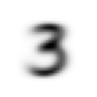

In [64]:
mean3 = stack_threes.mean(0)
show_image(mean3)

this is the ideal number 3 based on all the numpy numbers gathered from the 7k handwritten 3s


<Axes: >

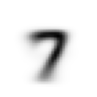

In [68]:
mean7 = stack_sevens.mean(0)
show_image(mean7)

### 

How can we determine its distasnce from our ideal 3 or 7? 
Should we just add up the differences between the pixels of this image and the ideal digit? 
Some differences will be positive while others will be negative since some areas with be 0 whiles others are darkened
**How can we avoid this**

**2 ways to measure distance in this context**

1. take the mean of the absolute value of differences . absolute value is the function that replaces negative values with positive values. ** Called the mean absolute difference or L1 norm
2. take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). this i called the ** root mean squared error (RMSE) or L2 norm


In [71]:
a_3 = stack_threes[1]
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3-mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [72]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr
     

(tensor(0.1586), tensor(0.3021))

as you can see from the results, the 3 is closer to the ideal 3 than the ideal 7. SO if we were to determine if am_3 is a 3 based on its distance form the "ideal" 3 or 7, we would say it is a 3

**Computing Metrics Using Broadcasting**

metric: a number that is calculated based on the predictions of our models, and the correct labels in our dataset, in order to tell us how good our model is

**we want to calculate our metric over a validation set to avoid overfitting**
